In [1]:
import cv2                  # working with, mainly resizing, images
import numpy as np          # dealing with arrays
import os                   # dealing with directories
from random import shuffle  # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [2]:
TRAIN_DIR = '/home/shreyas/PycharmProjects/After10:55/Training Set'
IMG_SIZE = 150
LR = 1e-4

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [Checks,Solids,Stripes]

    if word_label == 'Checks':
        return [1, 0, 0]

    elif word_label == 'Solids':
        return [0, 1, 0]

    elif word_label == 'Stripes':
        return [0, 0, 1]
    
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        try:
            path = os.path.join(TRAIN_DIR, img)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        except Exception as e:
            print(str(e))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

train_data = create_train_data()

100%|██████████| 845/845 [00:00<00:00, 893.55it/s] 


OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
train = train_data[75:]
print(len(train))
test = train_data[:75]

770


In [5]:
X1 = np.zeros((770, 150, 150))
for index, i in enumerate(train):
    X1[index] = i[0]
print(X1.shape)

(770, 150, 150)


In [6]:
X1 = X1.reshape(-1,IMG_SIZE,IMG_SIZE,1)
print(X1.shape)
Y = [i[1] for i in train]
X1 = X1 / 255

(770, 150, 150, 1)


In [7]:
test_x = np.zeros((75, 150, 150))

for index, i in enumerate(test):
    test_x[index] = i[0]
print(test_x.shape)

test_x = test_x.reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_x = test_x / 255
test_y = [i[1] for i in test]
print(test_x.shape)

(75, 150, 150)
(75, 150, 150, 1)


In [8]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 3, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
model.fit({'input': X1}, {'targets': Y}, n_epoch=65, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=100, show_metric=True)

Training Step: 844  | total loss: 0.57342 | time: 6.790s
| Adam | epoch: 065 | loss: 0.57342 - acc: 0.7959 -- iter: 768/770
Training Step: 845  | total loss: 0.56495 | time: 8.462s
| Adam | epoch: 065 | loss: 0.56495 - acc: 0.7913 | val_loss: 0.74582 - val_acc: 0.8800 -- iter: 770/770
--


In [38]:
TEST_DIR = '/home/shreyas/PycharmProjects/After10:55/Test Set'
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[1]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data
test_data = process_test_data()

100%|██████████| 38/38 [00:00<00:00, 682.20it/s]


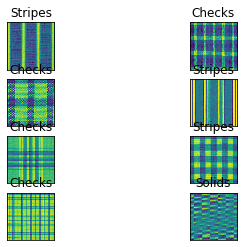

In [39]:
import matplotlib.pyplot as plt
fig=plt.figure()

for num,data in enumerate(test_data[:8]):
    
    # checks: [1, 0, 0]
    # solids: [0, 1, 0]
    # stripes: [0, 0, 1]
    
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4,2,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Solids'
    elif np.argmax(model_out) == 2: 
        str_label='Stripes'
    else:
        str_label='Checks'
        
        
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [40]:
model.save('my_model.tflearn')

INFO:tensorflow:/home/shreyas/my_model.tflearn is not in all_model_checkpoint_paths. Manually adding it.
